# UNET

In [ ]:
# Download dataset from Google Drive
!pip install --upgrade --no-cache-dir gdown -q
!gdown 11QkuyBOY75X3gxXAm3pDH6g1KxT8NtoD

Downloading...
From: https://drive.google.com/uc?id=11QkuyBOY75X3gxXAm3pDH6g1KxT8NtoD
To: /content/pfcn.zip
100% 1.23G/1.23G [00:54<00:00, 22.8MB/s]


In [ ]:
# Extract the dataset, delete archive
!unzip -q pfcn.zip
!rm pfcn.zip sample_data -rf

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

from pprint import pprint
from torch.utils.data import DataLoader

In [ ]:
training_list = os.listdir('dataset/training')
testing_list = os.listdir('dataset/testing')

In [ ]:
training_samples, testing_samples = len(training_list) // 2, len(testing_list) // 2

In [ ]:
training_samples, testing_samples

(1700, 300)

In [ ]:
from torch.utils.data import Dataset, random_split
import torchvision.transforms.functional as TF
from PIL import Image
from io import BytesIO

class PortraitSegmentationDataset(Dataset):
    def __init__(self, count, set_path, samples=1000):
        super(PortraitSegmentationDataset, self).__init__()
        self.count = min(count, samples)
        self.set_path = set_path
    
    def __getitem__(self, idx):
        file_name = f"{idx+1:05}"
        image = Image.open(f"{self.set_path}/{file_name}.png")
        mask = Image.open(f"{self.set_path}/{file_name}_matte.png")

        # resize to 150x400
        image = TF.resize(image, (200, 150))
        mask = TF.resize(mask, (200, 150))

        # crop to 200x296
        image = TF.crop(image, 0, 4, 200, 146)
        mask = TF.crop(mask, 0, 4, 200, 146)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Skip alpha channel
        image = image[0:3, :, :]

        # Only take one channel
        mask = mask[0:1, :, :]

        return image, mask

    def __len__(self):
        return self.count

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

train_set = PortraitSegmentationDataset(training_samples, "dataset/training", samples=training_samples)
train_set, val_set = random_split(train_set, [0.85, 0.15])
test_set = PortraitSegmentationDataset(testing_samples, "dataset/testing", samples=testing_samples)

train_loader = DataLoader(train_set, batch_size=32)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

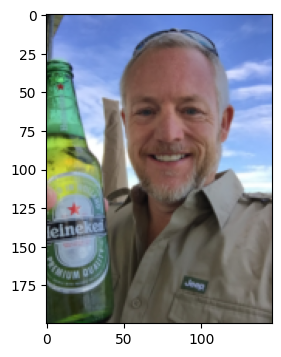

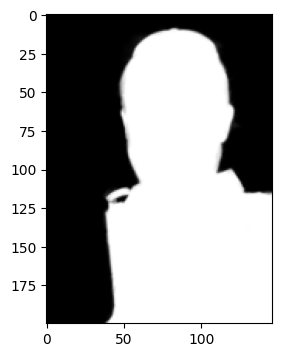

In [ ]:
image, mask = train_set[1]

plt.subplot(1,2,1)
plt.imshow(image.permute(1, 2, 0))
plt.show()

plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
image.shape

torch.Size([3, 200, 146])

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

"""
torch.Size([32, 3, 200, 146])
torch.Size([32, 64, 100, 73])
torch.Size([32, 64, 100, 73])
torch.Size([32, 64, 100, 73])
torch.Size([32, 64, 50, 37])
torch.Size([32, 256, 50, 37])
torch.Size([32, 128, 25, 18])
torch.Size([32, 512, 25, 18])
torch.Size([32, 256, 12, 9])
torch.Size([32, 1024, 12, 9])
torch.Size([32, 512, 6, 4])
torch.Size([32, 1024, 6, 4])
"""

class PortUNet(nn.Module):
  def __init__(self):
    super(PortUNet, self).__init__()
    # Define the encoder layers
    self.dense_net = models.densenet121(pretrained=True)
    self.freeze_pretrained_model(False)

    # Define the decoder layers
    self.dec1 = nn.Conv2d(1024+1024, 512, 3, padding=1)
    self.d_bn1 = nn.BatchNorm2d(512)

    self.dec2 = nn.Conv2d(512+512, 256, 5, padding=1)
    self.d_bn2 = nn.BatchNorm2d(256)
    
    self.dec3 = nn.Conv2d(256+256, 128, 5, padding=1)
    self.d_bn3 = nn.BatchNorm2d(128)
    
    self.dec4 = nn.Conv2d(64+128, 16, 7, padding=1)
    self.d_bn4 = nn.BatchNorm2d(16)

    self.dec5 = nn.Conv2d(16, 1, 9, padding=1)

  def forward(self, x):
    # Encode the input image
    features = [x]
    for _, layer in self.dense_net.features._modules.items():
        features.append(layer(features[-1]))

    enc6 = features[11]
    enc5 = features[9]
    enc4 = features[7]
    enc3 = features[5]
    enc2 = features[3]
    enc1 = features[0]

    _, _, H, W = enc5.shape
    up1 = nn.functional.interpolate(enc6, size=(H, W), mode='bilinear')
    dec1 = F.relu(self.d_bn1(self.dec1(torch.cat((up1, enc5), dim=1))))

    _, _, H, W = enc4.shape
    up2 = nn.functional.interpolate(dec1, size=(H, W), mode='bilinear')
    dec2 = F.relu(self.d_bn2(self.dec2(torch.cat((up2, enc4), dim=1))))

    _, _, H, W = enc3.shape
    up3 = nn.functional.interpolate(dec2, size=(H, W), mode='bilinear')
    dec3 = F.relu(self.d_bn3(self.dec3(torch.cat((up3, enc3), dim=1))))

    _, _, H, W = enc2.shape
    up4 = nn.functional.interpolate(dec3, size=(H, W), mode='bilinear')
    dec4 = F.relu(self.dec4(torch.cat((up4, enc2), dim=1)))

    _, _, H, W = enc1.shape
    up5 = nn.functional.interpolate(dec4, size=(H, W), mode='bilinear')
    dec5 = F.relu(self.dec5(up5))

    # Return the final decoded image
    return nn.functional.interpolate(dec5, size=(H, W), mode='bilinear')

  def freeze_pretrained_model(self, freeze: bool):
    for param in self.dense_net.features.parameters():
      param.requires_grad = not freeze

In [ ]:
model = PortUNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Losses

In [ ]:
import torch.nn.functional as F

def dice_loss_with_sigmoid(sigmoid, targets, smooth=1.0):
	"""
  Works
	sigmoid: (torch.float32)  shape (N, 1, H, W)
	targets: (torch.float32) shape (N, H, W), value {0,1}
	"""
	outputs = torch.squeeze(sigmoid, dim=0)

	inter = outputs * targets
	dice = 1 - ((2*inter.sum(dim=(0,)) + smooth) / (outputs.sum(dim=(0,))+targets.sum(dim=(0,)) + smooth))
	dice = dice.mean()
	return dice 

In [ ]:
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will train on {device}")
model = model.to(device)

optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.99)
# optimizer = Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min')
loss_func = nn.BCEWithLogitsLoss()

Model will train on cuda


- alter batch size (probably 64 or 128) (3rd)
- use learning rate scheduler (4th)
    - changes lr when in plateau
    - step learning rate
- try changing optimizer to SGD (2nd)
- try using Cross entropy (nn.CrossEntropyLoss) (1st)

In [ ]:
import time, sys
import matplotlib.pyplot as plt

def train(num_epochs: int):
    start_time = time.time()

    batch_size = 64
    training_steps = len(train_set) // batch_size
    val_steps = len(val_set) // batch_size

    training_losses = []
    val_losses = []

    best_avg_val_loss = sys.maxsize

    for epoch in range(num_epochs):
        model.train()

        total_training_loss = 0
        total_val_loss = 0

        for i, (images, labels) in enumerate(train_loader, 0):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred = model(images)
            loss = loss_func(pred, labels)

            loss.backward()
            optimizer.step()

            total_training_loss += loss.item()
                
        with torch.no_grad():
            model.eval()

            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                pred = model(images)
                total_val_loss += loss_func(pred, labels).item()

        avg_training_loss = total_training_loss / training_steps
        avg_val_loss = total_val_loss / val_steps

        training_losses.append(avg_training_loss)
        val_losses.append(avg_val_loss)

        print(f"{epoch+1}:{i+1} | TrainLoss: {avg_training_loss:.2f} | ValLoss: {avg_val_loss:.2f}")

        torch.cuda.empty_cache()

        if avg_val_loss < best_avg_val_loss:
            torch.save(model.state_dict(), "best_model.pth")
            best_avg_val_loss = avg_val_loss

    end_time = time.time()
    print(f"Total training time: {(end_time - start_time):.2f}s")
    return training_losses, val_losses

In [ ]:
training_losses, testing_losses = train(num_epochs=40)

1:46 | TrainLoss: 0.82 | ValLoss: 1.07
2:46 | TrainLoss: 0.70 | ValLoss: 0.97
3:46 | TrainLoss: 0.67 | ValLoss: 0.91
4:46 | TrainLoss: 0.65 | ValLoss: 0.89
5:46 | TrainLoss: 0.64 | ValLoss: 0.94
6:46 | TrainLoss: 0.63 | ValLoss: 0.88
7:46 | TrainLoss: 0.63 | ValLoss: 0.87
8:46 | TrainLoss: 0.63 | ValLoss: 0.88
9:46 | TrainLoss: 0.62 | ValLoss: 0.89
10:46 | TrainLoss: 0.62 | ValLoss: 0.89
11:46 | TrainLoss: 0.62 | ValLoss: 0.88
12:46 | TrainLoss: 0.62 | ValLoss: 0.90
13:46 | TrainLoss: 0.63 | ValLoss: 0.90
14:46 | TrainLoss: 0.63 | ValLoss: 1.00
15:46 | TrainLoss: 0.64 | ValLoss: 0.90
16:46 | TrainLoss: 0.63 | ValLoss: 0.92
17:46 | TrainLoss: 0.62 | ValLoss: 0.89
18:46 | TrainLoss: 0.62 | ValLoss: 0.89
19:46 | TrainLoss: 0.62 | ValLoss: 0.91
20:46 | TrainLoss: 0.62 | ValLoss: 0.92
21:46 | TrainLoss: 0.62 | ValLoss: 0.88
22:46 | TrainLoss: 0.62 | ValLoss: 0.89
23:46 | TrainLoss: 0.61 | ValLoss: 0.89
24:46 | TrainLoss: 0.62 | ValLoss: 0.90
25:46 | TrainLoss: 0.62 | ValLoss: 0.93
26:46 | T

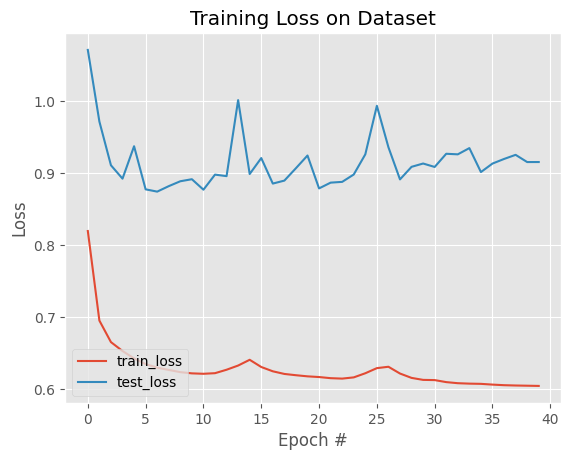

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(training_losses, label="train_loss")
plt.plot(testing_losses, label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("losses.jpg")

# Run tests on best model

In [ ]:
best_model = PortUNet()
best_model.load_state_dict(torch.load("best_model.pth"))
best_model = best_model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


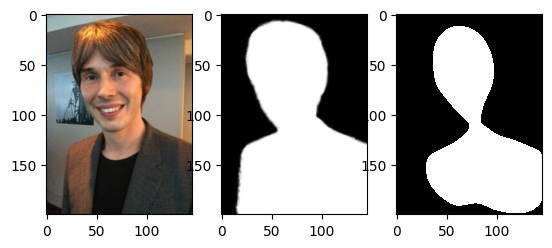

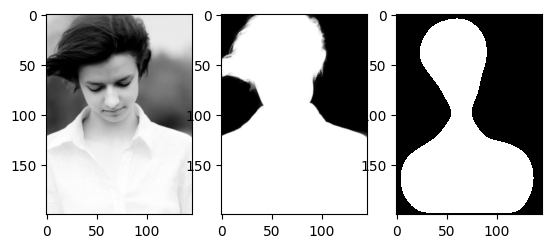

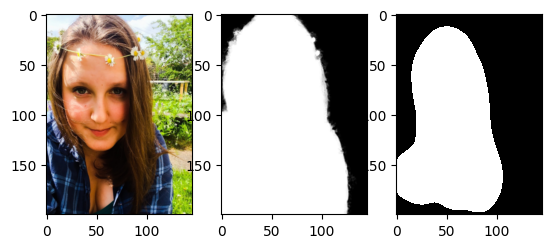

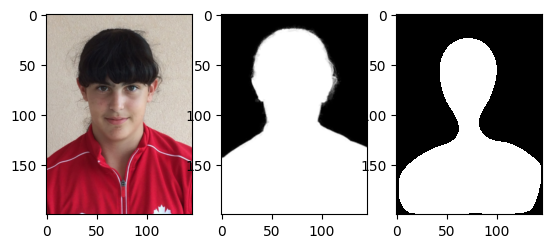

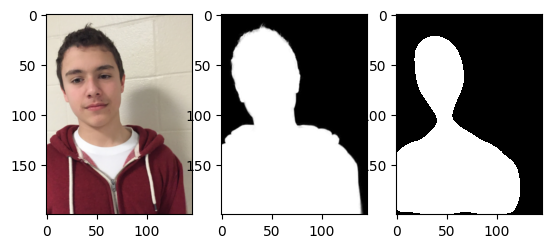

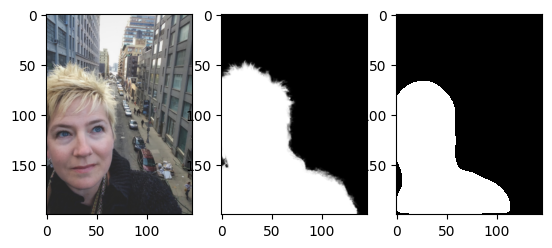

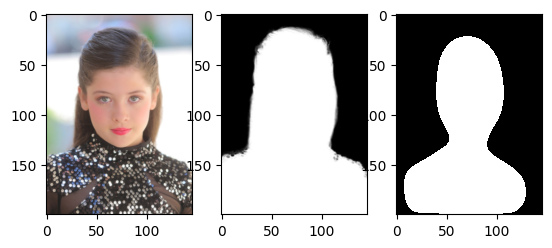

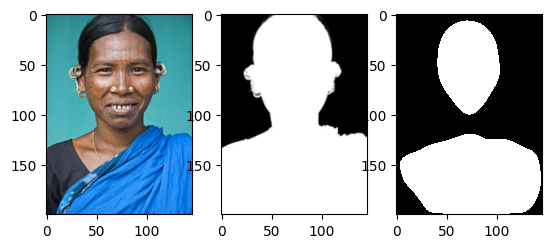

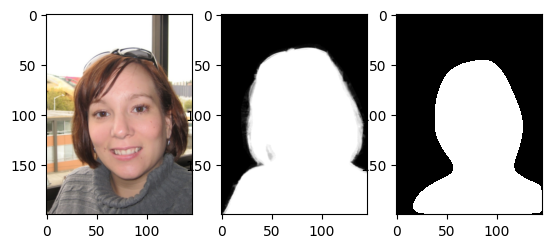

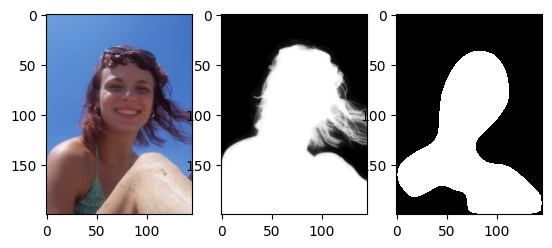

In [ ]:
import numpy as np

plt.style.use('default')

y_true = []
y_pred = []

with torch.no_grad():
  best_model.eval()
  for input_image, output_image in test_loader:
    input_image = input_image.to(device)
    model_output = best_model(input_image)[0]
    model_output = (model_output - model_output.mean()) / model_output.std()
    model_output = np.where(model_output.cpu().numpy() > 0, 1, 0)

    y_true.extend(output_image[0].cpu().numpy().squeeze().flatten().astype(np.uint8))
    y_pred.extend(model_output.squeeze().flatten())
    
    plt.subplot(1, 3, 1)
    plt.imshow(input_image[0].cpu().permute(1, 2, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(output_image[0].squeeze(), cmap=plt.get_cmap('gray'))
    plt.subplot(1, 3, 3)
    plt.imshow(model_output.squeeze(), cmap=plt.get_cmap('gray'))
    plt.show()

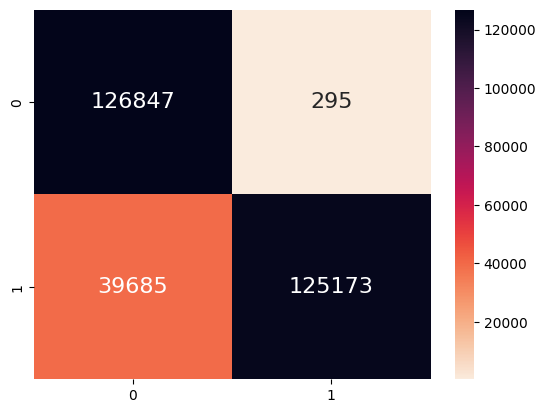

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="rocket_r")
plt.show()